In [4]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision.utils import save_image

import numpy as np

In [5]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060 6GB'

  2%|▏         | 3014656/170498071 [00:19<05:24, 515338.81it/s]

In [3]:
# Loading and Transforming data
transform = transforms.Compose([transforms.ToTensor()])

trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor()])

trainset = tv.datasets.CIFAR10(root='./data',  train=True,download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, num_workers=4)

testset = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

0it [00:00, ?it/s]

  2%|▏         | 2940928/170498071 [00:05<05:25, 515338.81it/s]

KeyboardInterrupt: 

In [6]:
class UpsamplingBilinear2d(nn.Module):
    def __init__(self, scale_factor):
        super(UpsamplingBilinear2d, self).__init__()
        self.scale = scale_factor
    
    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return x


class Reshape(torch.nn.Module):
    def __init__(self, n):
        super(Reshape, self).__init__()
        self.n = n

    def forward(self, x):
        x = x.view(-1, self.n)
        return x
      
class UnReshape(torch.nn.Module):
    def __init__(self, shape):
        super(UnReshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        x = x.view(-1, self.shape[0], self.shape[1], self.shape[2])
        return x


class ShowShape(torch.nn.Module):
    def __init__(self, mod):
        super(ShowShape, self).__init__()
        self.mod = mod
    
    def forward(self, x):
        x = self.mod(x)
        print(x.shape)
        return x


# Writing our model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            # 3x32x32 -> 64x28x28
            nn.Conv2d(3, 64, kernel_size=5),

            # 64x28x28 -> 64x14x14
            nn.MaxPool2d(2),

            # 64x14x14 -> 128x10x10
            nn.Conv2d(64, 128, kernel_size=5),

            # 128x10x10 -> 128x8x8
            nn.Conv2d(128, 128, kernel_size=3),

            # 128x6x6 -> 128x6x6
            nn.Conv2d(128, 128, kernel_size=3),

            # 128x6x6 -> 128x4x4
            nn.Conv2d(128, 128, kernel_size=3),

            # 128x4x4 -> 96x2x2
            nn.Conv2d(128, 96, kernel_size=3),

            # 96x2x2 -> 96x1x1
            nn.MaxPool2d(2),


        )
        self.decoder = nn.Sequential(
            UpsamplingBilinear2d(scale_factor=2),

            nn.ConvTranspose2d(96, 512, kernel_size=3),

            nn.ConvTranspose2d(512, 128, kernel_size=3),

            nn.ConvTranspose2d(128, 128, kernel_size=3),


            nn.ConvTranspose2d(128, 128, kernel_size=3),


            nn.ConvTranspose2d(128, 256, kernel_size=3),

            UpsamplingBilinear2d(scale_factor=2),

            nn.ConvTranspose2d(256, 12, kernel_size=5),

            nn.ConvTranspose2d(12, 3, kernel_size=5),

            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [7]:
model = Autoencoder().cuda()

distance = nn.MSELoss()#nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

In [13]:
T = torch.randn((1,3,32,32))

In [15]:
o = model.encoder(T.cuda())

In [22]:
from functools import reduce

reduce(lambda x,y: x*y, list(o.shape))

96

In [ ]:
num_epoch = 2
for epoch in range(num_epoch):
    for data in dataloader:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.5f}'.format(epoch+1, num_epoch, loss.data.item()))

epoch [1/3], loss:0.01241
epoch [2/3], loss:0.01079
epoch [3/3], loss:0.00928


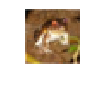

In [ ]:
import pylab as plt
x, _ = trainset[0]
plt.figure(figsize=(1,1))
plt.axis('off')
plt.imshow(x.permute(1,2,0).numpy())
plt.show()

In [ ]:
code = model.encoder(x.reshape(1,3,32,32).cuda())

In [ ]:
code.flatten().shape

torch.Size([96])

**Encode trainset**

In [ ]:
from tqdm import tqdm
encoded_trainset = np.zeros((
    len(trainset), 
    96 #128
))
for i in tqdm(range(len(trainset))):
  x, _ = trainset[i]
  x_encoded = model.encoder(x.reshape(1,3,32,32).cuda()).flatten()
  encoded_trainset[i] = x_encoded.cpu().detach().numpy()
 


100%|██████████| 50000/50000 [01:08<00:00, 728.14it/s]

In [ ]:
def showOriginDecoded(i):
  x, _ = trainset[i]
  plt.figure(figsize=(1,1))
  plt.axis('off')
  plt.imshow(x.permute(1,2,0).numpy())
  plt.show()
  
  x_encoded = model.encoder(x.reshape(1,3,32,32).cuda())
  #print(x_encoded)
  x_decoded = model.decoder(x_encoded)
  
  plt.figure(figsize=(1,1))
  plt.axis('off')
  plt.imshow(x_decoded[0].cpu().detach().numpy().swapaxes(0,2).swapaxes(0,1))
  plt.show()

In [ ]:
def showImage(x):
  plt.figure(figsize=(2,2))
  plt.axis('off')
  plt.imshow(x.permute(1,2,0).numpy(), interpolation='bilinear')
  plt.show()

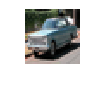

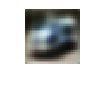

In [ ]:
showOriginDecoded(32)

**Encode Image from testset**

In [ ]:
from sklearn.neighbors import KDTree

In [ ]:
X = encoded_trainset  # 10 points in 3 dimensions
tree = KDTree(X, leaf_size=2)

In [ ]:
M = np.zeros((10,10), dtype=int)

In [ ]:
z = 0
for img in tqdm(range(9999)):
  t_index = img
  t, _ = testset[t_index]
  t_encoded = model.encoder(t.reshape(1,3,32,32).cuda()).flatten().cpu().detach().numpy()
    
  Y = t_encoded
  dist, ind = tree.query([Y], k=1)
  
  img_class  = trainset[ind[0][0]][1]
  img2_class = testset[t_index][1]
  M[img2_class][img_class] += int(1)
  if img_class == img2_class:
        z = z + 1
print(z)


100%|██████████| 9999/9999 [07:27<00:00, 20.98it/s]


4065


In [ ]:
print(z)

4065


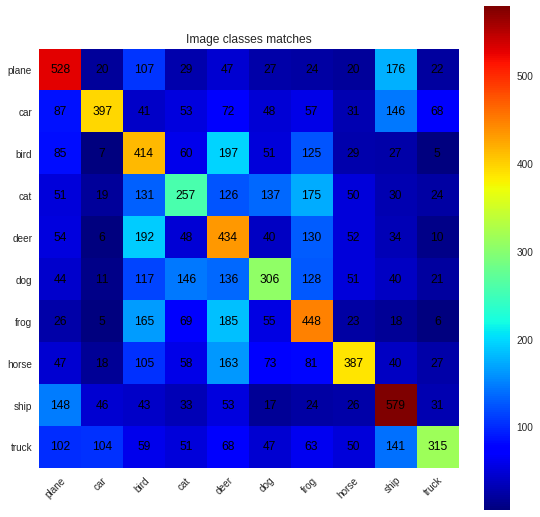

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# sphinx_gallery_thumbnail_number = 2

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']




fig, ax = plt.subplots(figsize=(8, 8))
#plt.axis('off')
plt.rcParams["axes.grid"] = False


im = ax.imshow(M, cmap=cm.jet)

# We want to show all ticks...
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, M[i, j],
                       ha="center", va="center", color="k")

ax.set_title("Image classes matches")
fig.tight_layout()
plt.colorbar(im, orientation='vertical')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

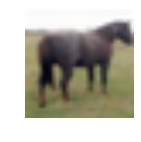

found
dist:4.474


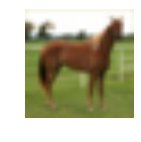

In [ ]:
t_index = 7888

t, _ = testset[t_index]
t_encoded = model.encoder(t.reshape(1,3,32,32).cuda()).flatten().cpu().detach().numpy()

Y = t_encoded
dist, ind = tree.query([Y], k=1)
showImage(testset[t_index][0])
print('found\ndist:{}'.format(round(dist[0][0], 3)))
showImage(trainset[ind[0][0]][0])

In [ ]:
x, _ = trainset[765]
x_encoded = model.encoder(x.reshape(1,3,32,32).cuda())
x_encoded.shape

torch.Size([1, 96, 1, 1])

In [ ]:
x_encoded

tensor([[[[-0.2958]],

         [[ 0.2766]],

         [[ 0.0856]],

         [[ 0.1452]],

         [[-0.6673]],

         [[-0.2435]],

         [[ 0.1724]],

         [[ 0.3302]],

         [[ 0.2525]],

         [[ 1.1526]],

         [[ 0.0922]],

         [[-0.8274]],

         [[ 0.3407]],

         [[ 1.0872]],

         [[ 0.6112]],

         [[-0.2063]],

         [[ 0.1806]],

         [[-0.3941]],

         [[-0.3794]],

         [[-0.0553]],

         [[ 0.1870]],

         [[-0.2335]],

         [[-0.1617]],

         [[ 0.5909]],

         [[ 0.3650]],

         [[-0.7952]],

         [[-0.0648]],

         [[-0.0593]],

         [[ 0.8873]],

         [[-0.9531]],

         [[-0.3512]],

         [[ 0.2482]],

         [[ 0.0358]],

         [[-0.0759]],

         [[-0.2717]],

         [[ 0.0508]],

         [[ 0.7873]],

         [[-0.8948]],

         [[-0.5127]],

         [[-0.0380]],

         [[-0.1028]],

         [[-0.7408]],

         [[-1.4025]],

         [[

In [ ]:
for i in range(0,int(neurons_per_layer/(koef ** linear_layers))): #128
  code = torch.zeros(1,int(neurons_per_layer/(koef ** linear_layers))) #128
  code[0,i] = -465

  x_decoded = model.decoder(code.cuda())

  plt.figure(figsize=(1,1))
  plt.imshow(x_decoded[0].cpu().detach().numpy().swapaxes(0,2).swapaxes(0,1))
  plt.show()

NameError: ignored

In [ ]:
x_decoded.shape

In [ ]:
img = model.encoder(x_decoded)

In [ ]:
plt.plot(img.cpu().detach().numpy()[0])

**HyperOpt**

In [ ]:
def trainAndGetLoss(params):
    print(params)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    dataset = trainset

    datagenerator = torch.utils.data.DataLoader(dataset=dataset, batch_size=64, shuffle=True)

    net = Autoencoder(params[0], params[1], params[2]).cuda()
    optimizer = torch.optim.Adam(net.parameters(),weight_decay=1e-5)
    criterion = nn.MSELoss()

    EPOCHS = 2
    
    
    #epochs = tqdm(range(EPOCHS))
    losses = np.zeros(EPOCHS)

    net.train()

    for epoch in range(EPOCHS):
        for batch in datagenerator:
            img, _ = batch
            img = Variable(img).cuda()
            

            optimizer.zero_grad()
            output = net(img)
            loss = criterion(output, img)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[epoch] += loss.item()

        #EPOCHS.set_description("\nloss: {}\n".format(round(losses[epoch] / len(datagenerator), 3)))
    
    return losses[epoch]/len(datagenerator)


          
          
def f(x):
    res = trainAndGetLoss([x['layers_num'], x['linear_neurons'], x['koef']])
    return res


space = {
    'layers_num': hp.choice('layers_num', [1, 2, 3]),
    'linear_neurons': hp.choice('linear_neurons', [512, 1024]),
    'koef': hp.choice('koef', [2, 4]),

}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=10, trials=trials, verbose=1)

print("best: {}".format(best))




вариант дающий 
41,4%

In [ ]:
class UpsamplingBilinear2d(nn.Module):
    def __init__(self, scale_factor):
        super(UpsamplingBilinear2d, self).__init__()
        self.scale = scale_factor
    
    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return x


class Reshape(torch.nn.Module):
    def __init__(self, n):
        super(Reshape, self).__init__()
        self.n = n

    def forward(self, x):
        x = x.view(-1, self.n)
        return x
      
class UnReshape(torch.nn.Module):
    def __init__(self, shape):
        super(UnReshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        x = x.view(-1, self.shape[0], self.shape[1], self.shape[2])
        return x


class ShowShape(torch.nn.Module):
    def __init__(self, mod):
        super(ShowShape, self).__init__()
        self.mod = mod
    
    def forward(self, x):
        x = self.mod(x)
        print(x.shape)
        return x


# Writing our model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            # 3x32x32 -> 64x28x28
            nn.Conv2d(3, 64, kernel_size=5),

            # 64x28x28 -> 64x14x14
            nn.MaxPool2d(2),

            # 64x14x14 -> 128x10x10
            nn.Conv2d(64, 128, kernel_size=5),

            # 128x10x10 -> 128x8x8
            nn.Conv2d(128, 128, kernel_size=3),

            # 128x6x6 -> 128x6x6
            nn.Conv2d(128, 128, kernel_size=3),

            # 128x6x6 -> 128x4x4
            nn.Conv2d(128, 128, kernel_size=3),

            # 128x4x4 -> 96x2x2
            nn.Conv2d(128, 96, kernel_size=3),

            # 96x2x2 -> 96x1x1
            nn.MaxPool2d(2),


        )
        self.decoder = nn.Sequential(
            UpsamplingBilinear2d(scale_factor=2),

            nn.ConvTranspose2d(96, 128, kernel_size=3),

            nn.ConvTranspose2d(128, 128, kernel_size=3),

            nn.ConvTranspose2d(128, 128, kernel_size=3),

            nn.ConvTranspose2d(128, 128, kernel_size=3),

            nn.ConvTranspose2d(128, 64, kernel_size=5),

            UpsamplingBilinear2d(scale_factor=2),

            nn.ConvTranspose2d(64, 3, kernel_size=5),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
